In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [30]:
# Define Data
x_ = np.arange(-10., 10., .1)
y_ = (np.sin(0.5 * x_) * 3.0 + x_ * 0.5).astype(np.float32)
func = lambda x,f : np.random.normal(x,x**2./f,1)
y1 = []
y2 = []
x1 = []
x2 = []
x = []
y = []
for idx, i in enumerate(y_):
	for j in range(50):
		noise = np.random.normal(0,1,1)
		y1_ = list(func(i,15.)+noise)
		y2_ = list(func(i+12,100.)+noise)
		y1+=y1_
		y2+=y2_
		x1.append(x_[idx])
		x2.append(x_[idx])
		y+=y1_+y2_
		x+=[x_[idx],x_[idx]]
y1 = np.array(y1).reshape((-1,1)).astype(np.float32)
x1 = np.array(x1).reshape((-1,1)).astype(np.float32)
y2 = np.array(y2).reshape((-1,1)).astype(np.float32)
x2 = np.array(x2).reshape((-1,1)).astype(np.float32)
y = np.array(y).reshape((-1,1)).astype(np.float32)
x = np.array(x).reshape((-1,1)).astype(np.float32)

Text(0, 0.5, 'Y')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


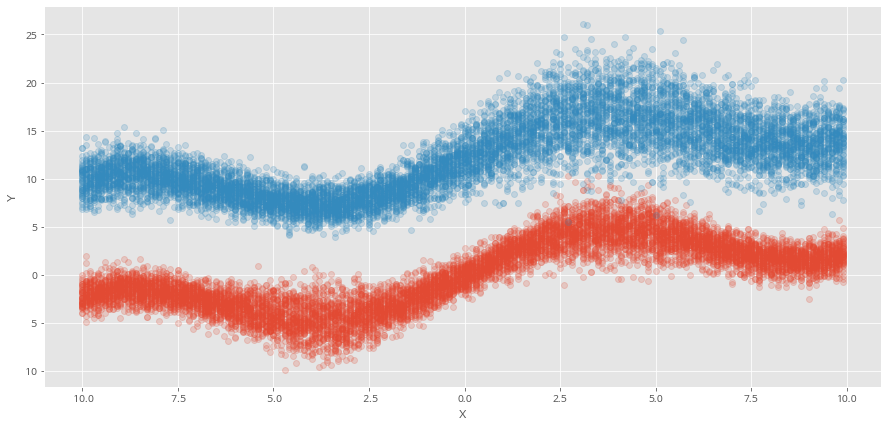

In [31]:
fig,axs=plt.subplots(1,1,figsize=(15,7))
plt.plot(x1,y1,'.',markersize=12, alpha=0.2)
plt.plot(x2,y2,'.',markersize=12, alpha=0.2)
plt.xlabel("X")
plt.ylabel("Y")

In [32]:

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(50,20,20,20))
mlp.fit(x,y)

/root/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 20, 20, 20), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [33]:
stdError = np.sqrt(np.mean((mlp.predict(x) - y)**2.))
mlp.loss_, stdError

(19.52924466341992, 7.800095924244231)

In [34]:
random_samples = []
for mu in x:
    random_samples+=list(np.random.normal(mlp.predict(x),stdError,1))

Text(0, 0.5, 'Y')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


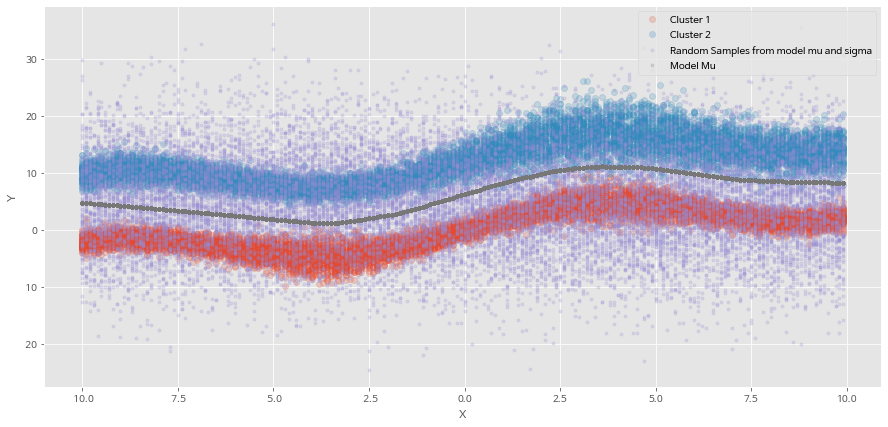

In [35]:
fig,axs=plt.subplots(1,1,figsize=(15,7))
plt.plot(x1,y1,'.',markersize=12, alpha=0.2)
plt.plot(x2,y2,'.',markersize=12, alpha=0.2)
plt.plot(x, random_samples, '.', alpha=0.2)
plt.plot(x, mlp.predict(x), '.', alpha=0.2)
plt.legend(["Cluster 1", "Cluster 2", "Random Samples from model mu and sigma", "Model Mu"])
plt.xlabel("X")
plt.ylabel("Y")

In [39]:
import tensorflow as tf
import tensorflow_probability as tfp
# TensorFlow Probability 0.7
class Network:
    def __init__(self, x, y, K=50):
        self.x = x
        self.layer_1 = tf.layers.dense(x, units=50, activation=tf.nn.tanh)
        self.layer_2 = tf.layers.dense(self.layer_1, units=20, activation=tf.nn.tanh)
        self.layer_3 = tf.layers.dense(self.layer_2, units=20, activation=tf.nn.tanh)
        self.layer_4 = tf.layers.dense(self.layer_3, units=20, activation=tf.nn.tanh)
        self.mu = tf.layers.dense(self.layer_4, units=K, activation=None, name="mu")
        self.var = tf.exp(tf.layers.dense(self.layer_4, units=K, activation=tf.nn.softplus, name="sigma"))
        self.pi = tf.layers.dense(self.layer_4, units=K, activation=tf.nn.softmax, name="mixing")

        # -------------------- Not using TF Mixture Family ------------------------
        # self.likelihood = tfp.distributions.Normal(loc=self.mu, scale=self.var)
        # self.out = self.likelihood.prob(y)
        # self.out = tf.multiply(self.out, self.pi)
        # self.out = tf.reduce_sum(self.out, 1, keepdims=True)
        # self.out = -tf.log(self.out + 1e-10)
        # self.mean_loss = tf.reduce_mean(self.out)

        # -------------------- Using TF Mixture Family ------------------------
        self.mixture_distribution = tfp.distributions.Categorical(probs=self.pi)
        self.distribution = tfp.distributions.Normal(loc=self.mu, scale=self.var)
        self.likelihood = tfp.distributions.MixtureSameFamily(
                                                            mixture_distribution=self.mixture_distribution,
                                                            components_distribution=self.distribution)
        self.log_likelihood = -self.likelihood.log_prob(tf.transpose(y))
        self.mean_loss = tf.reduce_mean(self.log_likelihood)
        # ----------------------------------------------------------------------

        self.global_step = tf.Variable(0, trainable=False)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.01, decay=0.8).minimize(self.mean_loss)
        self.init = tf.global_variables_initializer()

        # Initialize coefficients
        self.sess = tf.Session()
        self.sess.run(self.init)

In [40]:
n=len(x)
EPOCHS = 5000
BATCH_SIZE=n
tf.reset_default_graph()
dataset = tf.data.Dataset \
                        .from_tensor_slices((x, y)) \
                        .repeat(EPOCHS).shuffle(n).batch(BATCH_SIZE)
iter_ = dataset.make_one_shot_iterator()
x_, y_ = iter_.get_next()

network = Network(x_,y_,2)

best_loss = 1e+10
for i in range(EPOCHS * (n//BATCH_SIZE)):
    _, loss, mu, var, pi, x__ = network.sess.run([network.train_op,
                                                    network.mean_loss,
                                                    network.mu, network.var, network.pi,
                                                    network.x])

    if loss < best_loss:
        best_mu = mu
        best_var = var
        best_pi = pi
        best_mean_y = mu[:,0]
        best_x = x__
        best_loss = loss
        print("Epoch: {} Loss: {:3.3f}".format(i, loss))

Epoch: 0 Loss: 7.389
Epoch: 1 Loss: 5.355
Epoch: 2 Loss: 4.914
Epoch: 3 Loss: 4.612
Epoch: 4 Loss: 4.446
Epoch: 5 Loss: 4.269
Epoch: 6 Loss: 4.151
Epoch: 7 Loss: 4.079
Epoch: 8 Loss: 3.991
Epoch: 9 Loss: 3.925
Epoch: 10 Loss: 3.873
Epoch: 11 Loss: 3.821
Epoch: 12 Loss: 3.789
Epoch: 13 Loss: 3.752
Epoch: 14 Loss: 3.723
Epoch: 15 Loss: 3.698
Epoch: 16 Loss: 3.666
Epoch: 17 Loss: 3.647
Epoch: 18 Loss: 3.625
Epoch: 19 Loss: 3.608
Epoch: 20 Loss: 3.593
Epoch: 21 Loss: 3.582
Epoch: 22 Loss: 3.564
Epoch: 23 Loss: 3.552
Epoch: 24 Loss: 3.535
Epoch: 25 Loss: 3.528
Epoch: 26 Loss: 3.515
Epoch: 31 Loss: 3.487
Epoch: 33 Loss: 3.471
Epoch: 35 Loss: 3.433
Epoch: 39 Loss: 3.368
Epoch: 41 Loss: 3.365
Epoch: 43 Loss: 3.333
Epoch: 44 Loss: 3.329
Epoch: 46 Loss: 3.322
Epoch: 47 Loss: 3.320
Epoch: 48 Loss: 3.279
Epoch: 50 Loss: 3.266
Epoch: 52 Loss: 3.223
Epoch: 56 Loss: 3.191
Epoch: 57 Loss: 3.175
Epoch: 58 Loss: 3.167
Epoch: 59 Loss: 3.162
Epoch: 60 Loss: 3.157
Epoch: 65 Loss: 3.132
Epoch: 66 Loss: 3.12

/root/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


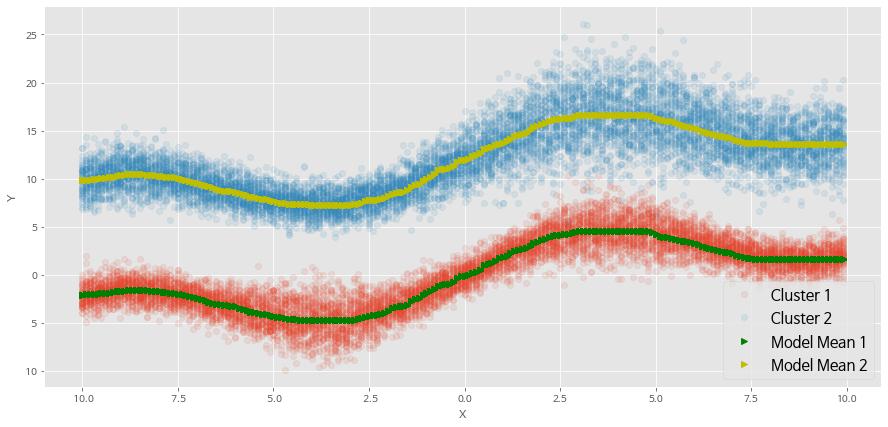

In [41]:
fig,axs=plt.subplots(1,1,figsize=(15,7))
plt.plot(x1,y1,'.',markersize=12, alpha=0.1)
plt.plot(x2,y2,'.',markersize=12, alpha=0.1)
plt.plot(best_x, best_mu[:,1], '>', color='G')
plt.plot(best_x, best_mean_y, '>', color='Y')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Cluster 1",
            "Cluster 2",
            "Model Mean 1",
            "Model Mean 2"], loc='lower right',fontsize=15)

In [42]:
random_samples_2 = []
for mu,sigma in zip(best_mu[:,0], best_var[:,0]):
    random_samples_2+=list(np.random.normal(mu,sigma,1))
    
random_samples_1 = []
for mu,sigma in zip(best_mu[:,1], best_var[:,1]):
    random_samples_1+=list(np.random.normal(mu,sigma,1))

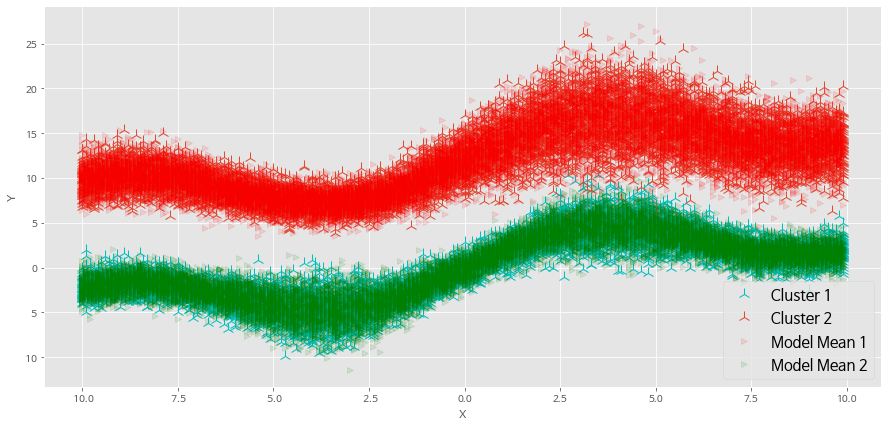

In [43]:
fig,axs=plt.subplots(1,1,figsize=(15,7))
plt.plot(x1,y1,'2',markersize=12,color='c')
plt.plot(x2,y2,'2',markersize=12)
plt.plot(best_x, random_samples_2, '>', color='r', alpha=0.1)
plt.plot(best_x, random_samples_1, '>', color='g', alpha=0.1)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Cluster 1",
            "Cluster 2",
            "Model Mean 1",
            "Model Mean 2"], loc='lower right',fontsize=15)

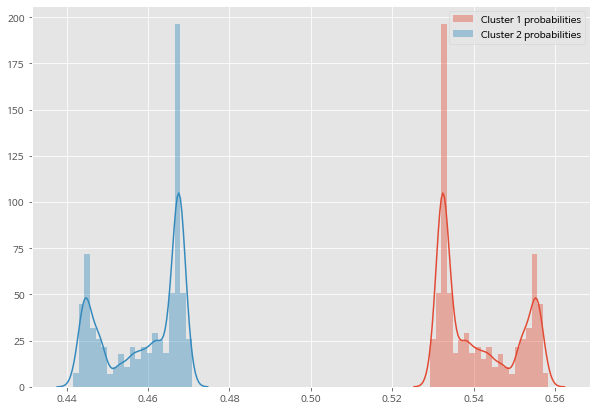

In [44]:
fig,axs=plt.subplots(1,1,figsize=(10,7))
sns.distplot(best_pi[:,1])
sns.distplot(best_pi[:,0])
plt.legend(["Cluster 1 probabilities", 
            "Cluster 2 probabilities"])